# Demo: pciSeq
This is a example showing how to use pciSeq to cell type iss data

## Installation:

In [1]:
!pip install pciSeq==0.0.56

Other libraries needed for this notebook:

In [2]:
import os
import numpy as np
import pandas as pd
import skimage.color
import matplotlib.pyplot as plt
from scipy.sparse import load_npz, coo_matrix
import pciSeq

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Dec 13 2022)
For more information see https://diplib.org


In [3]:
pciSeq.__version__

'0.0.56'

## 1. Loading the data

The required inputs are:
* Segmentation
* Spots
* Single cell data

### 1.1. The segmentation array
This should be a labelled array of coo_matrix datatype. The labels correspond to the objects (nuclei) that were detected during segmentation. A label of value = 0 denotes the background

In [4]:
coo_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/segmentation/label_image.coo.npz?raw=true')
coo = load_npz(coo_file)
print('The image has %d cells' % len(set(coo.data)))

The image has 3481 cells


Let's now plot the segmented cells:

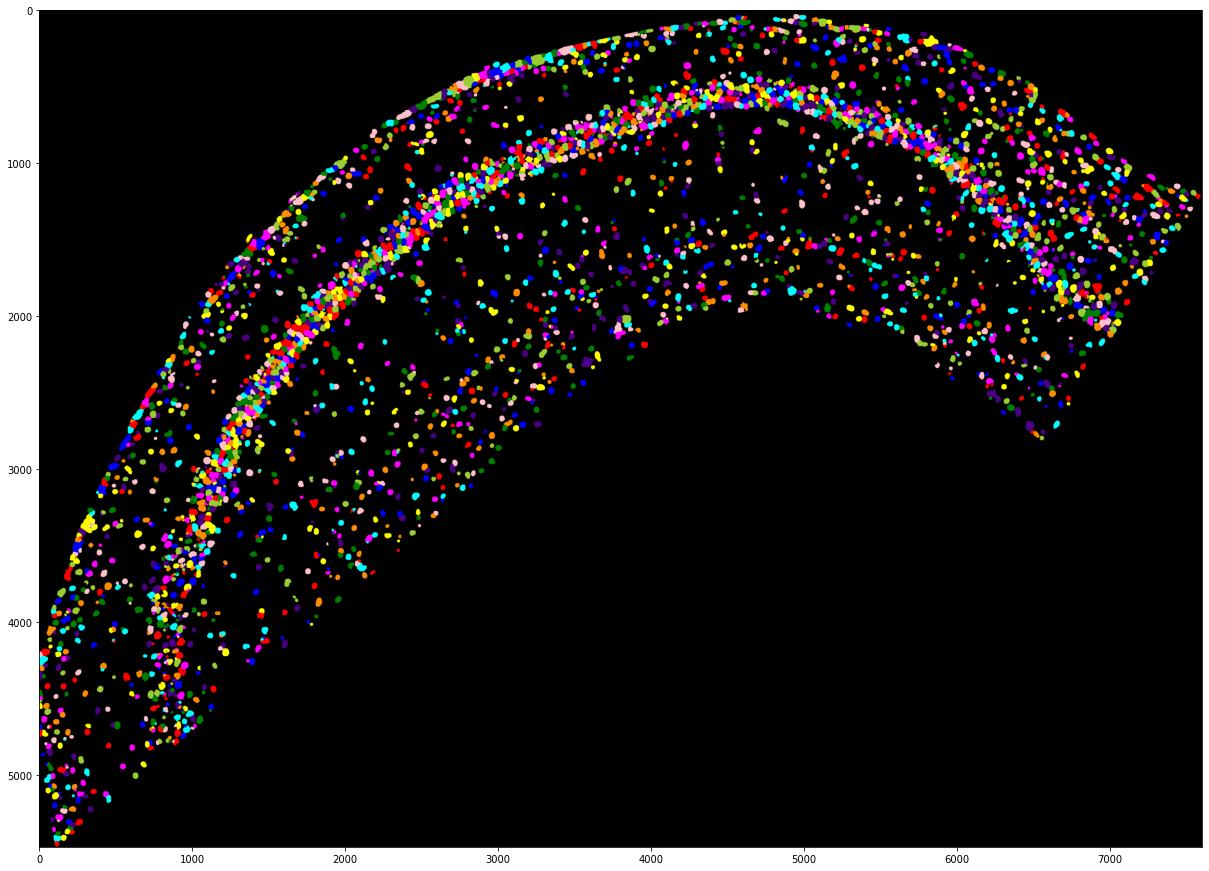

In [5]:
rgb_label_image = skimage.color.label2rgb(coo.toarray(), bg_label=0)
_dpi = 72
plt.figure(figsize=(1500/_dpi, 1500/_dpi), dpi=_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.show()

### 1.2. The spots

The spots should be a dataframe with column names: 'Gene', 'x', 'y'.

In [6]:
spots_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/iss/spots.csv?raw=true')
iss_spots = pd.read_csv(spots_file)
iss_spots.head()

Downloading: "https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/iss/spots.csv?raw=true" to spots.csv
100%|██████████| 1.10M/1.10M [00:00<00:00, 20.6MB/s]


,Gene,x,y
0,Cxcl14,110,5457
1,Plp1,-1,4735
2,Plp1,-1,4725
3,Id2,-1,4478
4,Enpp2,-1,4455


### **Caution!**
It is important to make sure that the spots and the segmentation array are not misaligned. If the **orign** of the ROI containing our spots is not at [0, 0] then the spot coords must be shifted and/or flipped in such a manner that they are inline with the segmentation data.

We can overlay the spots to the cells to quickly check whether this holds

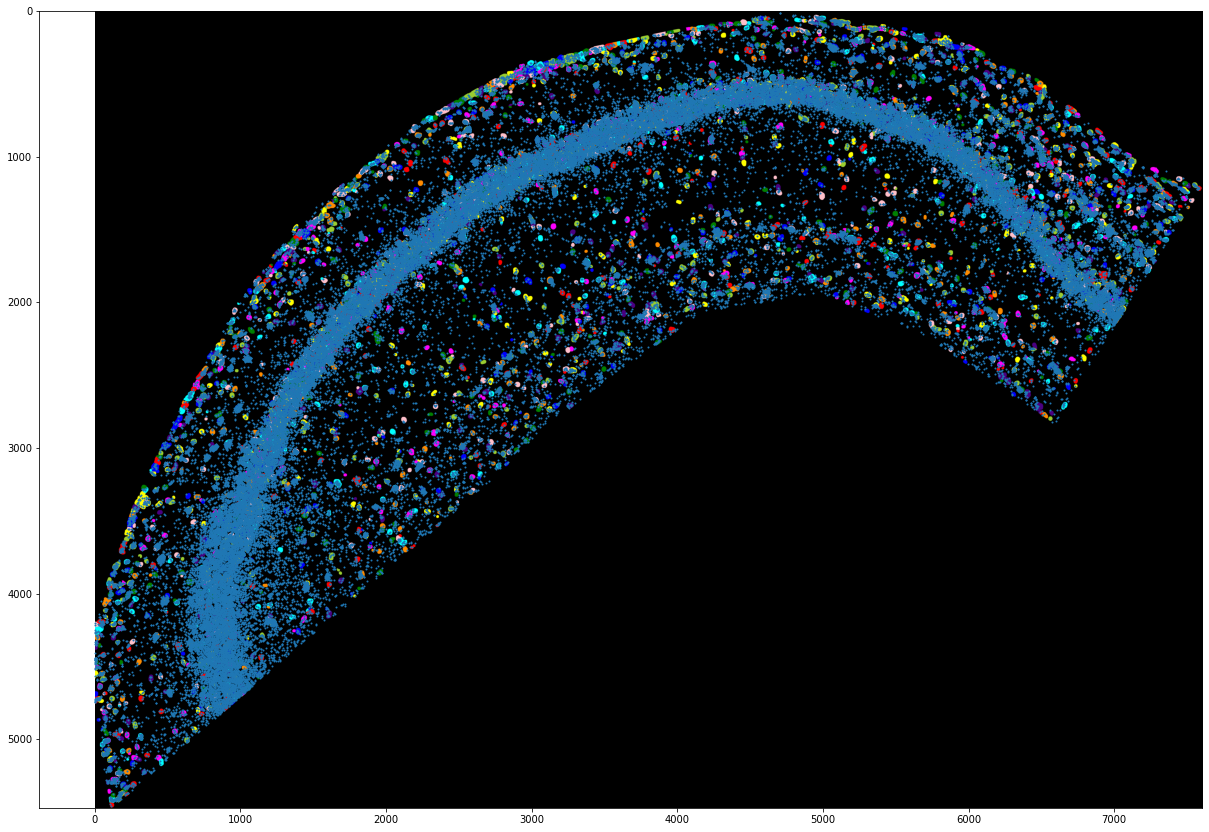

In [7]:
my_dpi = 72
plt.figure(figsize=(1500/my_dpi, 1500/my_dpi), dpi=my_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.scatter(iss_spots.x, iss_spots.y, s=1)
plt.show()

### 1.3. The single cell data.
#### This is optional, not required for this built. However the code works if we have single cell data and we want to feed them to the algorithm, hence we have this paragraph here

This is another dataframe with columns the cell classes and rows the genes. The expression data are UMI counts as they come from single cell sequencing.


##### A note on the gene inefficiency
It is worth highlighting here that if the counts are not UMI (could be FPKM for example) then you need to take some action. FPKM counts are orders of magnitude larger than UMI, hence you could either:

* Divide the single cell data by something like 1000 or
* Divide the value of the 'Inefficiency' hyperparameter by 1000

In general, regardless UMI or FPKM, a rule of thumb to set the initial value of the gene inefficiency hyperparamter is to keep in mind that it tries to express how well a gene is detected, hence setting it to the ratio of actual/predicted counts sounds like a reasonable choice. Here, actual means the gene counts you expect from the data and predicted its counterpart from the single cell matrix. The initial value for the gene inefficiency doesnt have to be dead right, it is just a starting point to get the algorithm started. But if it is 1000 times off then it wont be able to compare the infered cell gene counts to those from the single cell data and all cells quite likely will be classed as Zero class.

In [8]:
sc_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/scRNA/scRNAseq.csv.gz?raw=true')
scRNAseq = pd.read_csv(sc_file, header=None, index_col=0, compression='gzip', dtype=object)
scRNAseq = scRNAseq.rename(columns=scRNAseq.iloc[0], copy=False).iloc[1:]
scRNAseq = scRNAseq.astype(float).astype(np.uint32)

Downloading: "https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/scRNA/scRNAseq.csv.gz?raw=true" to scRNAseq.csv.gz
100%|██████████| 11.2M/11.2M [00:00<00:00, 96.4MB/s]


In [9]:
scRNAseq.head()

,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,...,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1
0,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Caution!**
It is worth noting that pciSeq internally works on the aggregated (mean) gene expressions from the single cell data. For any given gene, pciSeq will group the raw single cell data that the user feeds-in, by the cell type (aka class, aka cluster) to get the average counts per cell type. Hence, the headers (ie column names) of the single cell dataframe should reflect the cells' cell types. Then the code will group the dataframe by the cell type to yield an aggregated by the mean dataframe of shape numGenes-by-numCellTypes.

If the column names of the single cell dataframe that is passed-in to the fit() method are not the cell type labels, the group-by operator will not produce the correct mean gene expression per cell type.  

## 2. Cell typing

First, setup the logger

In [10]:
pciSeq.attach_to_log()

We can now do the cell typing:

In [11]:
cellData, geneData = pciSeq.fit(spots=iss_spots, coo=coo, scRNAseq=scRNAseq)

[2023-07-03 14:55:13] INFO    (app.py:251) check_redis_server
INFO:pciSeq:check_redis_server
[2023-07-03 14:55:13] INFO    (app.py:256) Redis ping failed!. Diagnostics will not be called unless redis is installed and the service is running
INFO:pciSeq:Redis ping failed!. Diagnostics will not be called unless redis is installed and the service is running
[2023-07-03 14:55:13] INFO    (app.py:126)  Preprocessing data
INFO:pciSeq: Preprocessing data
[2023-07-03 14:55:13] INFO    (spot_labels.py: 69)  Number of spots passed-in: 72336
INFO:pciSeq: Number of spots passed-in: 72336
[2023-07-03 14:55:14] INFO    (spot_labels.py: 70)  Number of segmented cells: 3481
INFO:pciSeq: Number of segmented cells: 3481
[2023-07-03 14:55:14] INFO    (spot_labels.py: 71)  Segmentation array implies that image has width: 7602px and height: 5471px
INFO:pciSeq: Segmentation array implies that image has width: 7602px and height: 5471px
[2023-07-03 14:55:33] INFO    (datatypes.py:460)  Single cell data passed-

## 3. Reading the results

The results are two dataframes, cellData and geneData, each one keeping the output from the cell calling algorithm that is mainly relevant to the cells and the genes (spots) respectivelly

### 3.1 The cellData

This dataframe keeps the coordinates of the cell centroid, the gene names of the spots assigned to each cell, with corresponding gene counts and class names with the associated posterior probabilities.

In [12]:
cellData.head()

,Cell_Num,X,Y,Genenames,CellGeneCount,ClassName,Prob
1,1,10.308869,4727.265036,"[6330403K07Rik, Cryab, Enpp2, Kctd12, Neurod6,...","[0.00944227323050972, 0.9305981205283594, 2.00...","[Oligo.1, Oligo.2, Oligo.3, Oligo.4, Oligo.5]","[0.30567884011504687, 0.07750333835639654, 0.2..."
2,2,9.487214,4687.432032,[Neurod6],[0.0016140190586065408],"[Endo, Eryth.1, Eryth.2, Microglia.1, Microgli...","[0.0016245932765691778, 0.008492659197546474, ..."
3,3,9.772246,4550.726695,"[3110035E14Rik, Enpp2, Id2, Rgs4, Slc6a1]","[0.0011447629930456027, 0.15975471163685392, 0...","[Astro.1, Astro.2, Astro.4, Astro.5, Endo, Ery...","[0.002910547354327257, 0.0025808287322291474, ..."
4,4,11.432247,4497.694683,"[Aldoc, Cryab, Cxcl14, Enpp2, Id2, Plp1, Pvalb...","[0.024290307625168334, 2.024423497315276, 0.87...","[Oligo.1, Oligo.2, Oligo.3, Oligo.4, Oligo.5]","[0.17009226000798686, 0.29905376523152866, 0.2..."
5,5,10.737006,4465.733888,"[Aldoc, Arpp21, Cryab, Cxcl14, Enpp2, Id2, Plp...","[0.29626491099707764, 0.004538206872103452, 2....","[Oligo.1, Oligo.2, Oligo.3, Oligo.4, Oligo.5]","[0.674463176862223, 0.09204757385575545, 0.144..."


Lets take for example the first entry in the dataframe.

The cell_id and centroid coordinates (x,y) are:

In [13]:
cellData.iloc[0].Cell_Num, (int(cellData.iloc[0].X), int(cellData.iloc[0].Y))

(1, (10, 4727))

The genes and their counts for that cell are

In [14]:
pd.DataFrame(zip(cellData.iloc[0].Genenames, cellData.iloc[0].CellGeneCount), columns=['Gene names', 'Gene counts'])

,Gene names,Gene counts
0,6330403K07Rik,0.009442
1,Cryab,0.930598
2,Enpp2,2.001089
3,Kctd12,0.021976
4,Neurod6,0.982957
5,Plp1,11.106007


Similarly, the cell types of that particular cell and the corresponding probabilities are

In [15]:
pd.DataFrame(zip(cellData.iloc[0].ClassName, cellData.iloc[0].Prob), columns=['Class name', 'Prob'])

,Class name,Prob
0,Oligo.1,0.305679
1,Oligo.2,0.077503
2,Oligo.3,0.213225
3,Oligo.4,0.378815
4,Oligo.5,0.024776


### 3.2 The geneData

This dataframe keeps the spots coordinates the cell_ids of the neighbouring cells and the posterior probabilities that the spot has been emerged by the correspondind cell. The column "neighbour" records the most likely such cell, ie the cell that has the highest probability of being the parent cell of the spot

In [16]:
geneData.head()

,Gene,Gene_id,x,y,neighbour,neighbour_array,neighbour_prob
0,Cxcl14,24,110,5457,51,"[51, 48, 73, 0]","[0.9338233162029546, 7.580339723163264e-07, 1...."
1,Enpp2,26,0,4741,1,"[1, 13, 2, 0]","[0.9942530562565014, 1.8946324493738694e-05, 2..."
2,Plp1,56,0,4517,4,"[10, 4, 3, 0]","[0.028309359138753837, 0.9566052242900177, 2.8..."
3,Id2,35,0,4484,4,"[4, 5, 10, 0]","[0.9129895331050268, 0.030495154437299013, 0.0..."
4,Cryab,21,0,4471,5,"[5, 4, 10, 0]","[0.9959441368680629, 0.002087140397702082, 1.5..."


Note that under the "neighbour_array" column there is a cell with label=0 which is present in all rows of the dataframe. This not a real biological cell. It has been introduced as a super-neighbour, something that is a neighbour to all the spots on the image, and its role is to get assigned all the misreads. It can be thought of as the background.